# Structured and time series data

In [426]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [427]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

PATH='data/stock/'

## Create datasets

preprocess data

In [428]:
def concat_csvs(dirname):
    path = f'{PATH}{dirname}'
    filenames=glob(f"{PATH}/*.csv")

    wrote_header = False
    with open(f"{path}.csv","w") as outputfile:
        for filename in filenames:
            name = filename.split(".")[0]
            with open(filename) as f:
                line = f.readline()
                if not wrote_header:
                    wrote_header = True
                    outputfile.write("file,"+line)
                for line in f:
                     outputfile.write(name + "," + line)
                outputfile.write("\n")

Feature Space:
* train: Training set provided by competition
* googletrend: trend of ethusd
* test: testing set

In [429]:
table_names = ['train']
#, 'test'
str('{PATH}{fname}.csv')

'{PATH}{fname}.csv'

We'll be using the popular data manipulation framework `pandas`. Among other things, pandas allows you to manipulate tables/data frames in python as one would in a database.

We're going to go ahead and load all of our csv's as dataframes into the list `tables`.

In [430]:

tables = [pd.read_csv(f'{PATH}{fname}.csv', low_memory=False) for fname in table_names]

In [431]:
from IPython.display import HTML

We can use `head()` to get a quick look at the contents of each table:
* train: Contains store information on a daily basis, tracks things like sales, customers, whether that day was a holdiay, etc.
* store: general info about the store including competition, etc.
* store_states: maps store to state it is in
* state_names: Maps state abbreviations to names
* googletrend: trend data for particular week/state
* weather: weather conditions for each state
* test: Same as training table, w/o sales and customers


In [432]:
for t in tables: display(t.head())

,timePeriodStart,priceLow,priceHigh,volumeTraded,tradesCount,priceOpen,priceClose,action,year,month,dayOfWeek,hour,minute,second
0,2017-08-05 04:00:00,224.12,226.67,5653.444047,1371,224.71,226.67,BUY,2017,7,6,4,0,0
1,2017-08-05 04:30:00,226.13,227.99,6549.737615,1079,226.69,227.99,HOLD,2017,7,6,4,30,0
2,2017-08-05 05:00:00,226.59,228.00,5815.729460,1009,227.99,227.54,BUY,2017,7,6,5,0,0
3,2017-08-05 05:30:00,226.33,227.99,1847.529597,567,227.54,226.41,BUY,2017,7,6,5,30,0
4,2017-08-05 06:00:00,226.40,227.80,1944.909268,522,226.41,227.47,BUY,2017,7,6,6,0,0


This is very representative of a typical industry dataset.

The following returns summarized aggregate information to each table accross each field.

In [433]:
for t in tables: display(DataFrameSummary(t).summary())

,timePeriodStart,priceLow,priceHigh,volumeTraded,tradesCount,priceOpen,priceClose,action,year,month,dayOfWeek,hour,minute,second
count,NaN,11586,11586,11586,11586,11586,11586,NaN,11586,11586,11586,11586,11586,11586
mean,NaN,556.617,564.339,3872.27,1954.54,560.846,560.856,NaN,2017.38,5.98343,4.00043,11.5095,14.9974,0
std,NaN,290.939,296.059,5128.63,1892.23,293.635,293.622,NaN,0.486461,4.07734,2.01065,6.91934,15.0006,0
min,NaN,1.9061,210,8.96028,12,202.86,202.85,NaN,2017,0,1,0,0,0
25%,NaN,303.01,305.317,1266.96,740,304.322,304.33,NaN,2017,2,2,6,0,0
50%,NaN,442.755,449.345,2343.84,1251,447.175,447.05,NaN,2017,8,4,12,0,0
75%,NaN,810.153,824.773,4381.26,2508,818.007,818.085,NaN,2018,10,6,18,30,0
max,NaN,1400,1419.96,78543.3,22174,1418.74,1418.61,NaN,2018,11,7,23,30,0
counts,11586,11586,11586,11586,11586,11586,11586,11586,11586,11586,11586,11586,11586,11586
uniques,11586,8510,8219,11586,4295,9223,9163,2,2,9,7,24,2,1


## Data Cleaning / Feature Engineering

In [434]:
train = tables[0]

In [435]:
len(train)

11586

In [436]:
def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", suffix))

delete unused

In [437]:

train.drop('second',1,inplace=True)
train.drop('minute',1,inplace=True)
train.drop('action',1,inplace=True)
#train.drop('timePeriodStart',1,inplace=True)



In [438]:
df = train
df.head()

,timePeriodStart,priceLow,priceHigh,volumeTraded,tradesCount,priceOpen,priceClose,year,month,dayOfWeek,hour
0,2017-08-05 04:00:00,224.12,226.67,5653.444047,1371,224.71,226.67,2017,7,6,4
1,2017-08-05 04:30:00,226.13,227.99,6549.737615,1079,226.69,227.99,2017,7,6,4
2,2017-08-05 05:00:00,226.59,228.00,5815.729460,1009,227.99,227.54,2017,7,6,5
3,2017-08-05 05:30:00,226.33,227.99,1847.529597,567,227.54,226.41,2017,7,6,5
4,2017-08-05 06:00:00,226.40,227.80,1944.909268,522,226.41,227.47,2017,7,6,6


It's usually a good idea to back up large tables of extracted / wrangled features before you join them onto another one, that way you can go back to it easily if you need to make changes to it.

In [439]:
df.columns

Index(['timePeriodStart', 'priceLow', 'priceHigh', 'volumeTraded',
       'tradesCount', 'priceOpen', 'priceClose', 'year', 'month', 'dayOfWeek',
       'hour'],
      dtype='object')

In [440]:
joined = df #join_df(joined, df, ['timePeriodStart'])

In [441]:
# joined.to_feather(f'{PATH}joined')

## Durations

We're going to set the active index to Date.

In [442]:
df = df.set_index("timePeriodStart")
df.head()

,priceLow,priceHigh,volumeTraded,tradesCount,priceOpen,priceClose,year,month,dayOfWeek,hour
timePeriodStart,,,,,,,,,,
2017-08-05 04:00:00,224.12,226.67,5653.444047,1371,224.71,226.67,2017,7,6,4
2017-08-05 04:30:00,226.13,227.99,6549.737615,1079,226.69,227.99,2017,7,6,4
2017-08-05 05:00:00,226.59,228.00,5815.729460,1009,227.99,227.54,2017,7,6,5
2017-08-05 05:30:00,226.33,227.99,1847.529597,567,227.54,226.41,2017,7,6,5
2017-08-05 06:00:00,226.40,227.80,1944.909268,522,226.41,227.47,2017,7,6,6


It is common when working with time series data to extract data that explains relationships across rows as opposed to columns, e.g.:
* Running averages
* Time until next event
* Time since last event

This is often difficult to do with most table manipulation frameworks, since they are designed to work with relationships across columns. As such, we've created a class to handle this type of data.

We'll define a function `get_elapsed` for cumulative counting across a sorted dataframe. Given a particular field `fld` to monitor, this function will start tracking time since the last occurrence of that field. When the field is seen again, the counter is set to zero.

Upon initialization, this will result in datetime na's until the field is encountered. This is reset every time a new store is seen. We'll see how to use this shortly.

In [443]:
df.reset_index(inplace=True)
#joined_test.reset_index(inplace=True)
df.head()

,timePeriodStart,priceLow,priceHigh,volumeTraded,tradesCount,priceOpen,priceClose,year,month,dayOfWeek,hour
0,2017-08-05 04:00:00,224.12,226.67,5653.444047,1371,224.71,226.67,2017,7,6,4
1,2017-08-05 04:30:00,226.13,227.99,6549.737615,1079,226.69,227.99,2017,7,6,4
2,2017-08-05 05:00:00,226.59,228.00,5815.729460,1009,227.99,227.54,2017,7,6,5
3,2017-08-05 05:30:00,226.33,227.99,1847.529597,567,227.54,226.41,2017,7,6,5
4,2017-08-05 06:00:00,226.40,227.80,1944.909268,522,226.41,227.47,2017,7,6,6


In [444]:
# df.to_feather(f'{PATH}df')

In [445]:
# df = pd.read_feather(f'{PATH}df')

In [446]:
#convert to date objects
df["timePeriodStart"] = pd.to_datetime(df.timePeriodStart)

In [447]:
df.columns

Index(['timePeriodStart', 'priceLow', 'priceHigh', 'volumeTraded',
       'tradesCount', 'priceOpen', 'priceClose', 'year', 'month', 'dayOfWeek',
       'hour'],
      dtype='object')

remove all 0 values 

In [448]:
joined = joined[joined.priceClose!=0]

In [449]:
joined.reset_index(inplace=True)

In [450]:
# joined.to_feather(f'{PATH}joined')

## Create features


In [451]:
# joined = pd.read_feather(f'{PATH}joined')

Delete unused

In [452]:
joined.head().T.head(40)

,0,1,2,3,4
index,0,1,2,3,4
timePeriodStart,2017-08-05 04:00:00,2017-08-05 04:30:00,2017-08-05 05:00:00,2017-08-05 05:30:00,2017-08-05 06:00:00
priceLow,224.12,226.13,226.59,226.33,226.4
priceHigh,226.67,227.99,228,227.99,227.8
volumeTraded,5653.44,6549.74,5815.73,1847.53,1944.91
tradesCount,1371,1079,1009,567,522
priceOpen,224.71,226.69,227.99,227.54,226.41
priceClose,226.67,227.99,227.54,226.41,227.47
year,2017,2017,2017,2017,2017
month,7,7,7,7,7


Now that we've engineered all our features, we need to convert to input compatible with a neural network.

This includes converting categorical variables into contiguous integers or one-hot encodings, normalizing continuous features to standard normal, etc...

In [453]:
cat_vars = ['hour', 'dayOfWeek', 'month', 'year']

contin_vars = ['priceOpen', 'tradesCount', 'volumeTraded', 'priceHigh', 'priceLow']

n = len(joined); n

11586

In [454]:
dep = 'priceClose'
joined = joined[cat_vars+contin_vars+[dep, 'timePeriodStart']].copy()


In [455]:
#joined_test = joined[cat_vars+contin_vars+[dep, 'timePeriodStart']].copy()


In [456]:
for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()


In [457]:
#apply_cats(joined_test, joined)

In [458]:
for v in contin_vars:
    joined[v] = joined[v].fillna(0).astype('float32')
    #joined_test[v] = joined_test[v].fillna(0).astype('float32')

To run on the full dataset, use this instead:

In [459]:
samp_size = n
joined_samp = joined.set_index("timePeriodStart")

In [460]:
joined_samp.head(2)

,hour,dayOfWeek,month,year,priceOpen,tradesCount,volumeTraded,priceHigh,priceLow,priceClose
timePeriodStart,,,,,,,,,,
2017-08-05 04:00:00,4,6,7,2017,224.710007,1371.0,5653.443848,226.669998,224.119995,226.67
2017-08-05 04:30:00,4,6,7,2017,226.690002,1079.0,6549.737793,227.990005,226.130005,227.99


In [461]:
df, y, nas, mapper = proc_df(joined_samp, 'priceClose', do_scale=True)
yl = np.log(y)

In [462]:
#joined_test = joined_test.set_index("timePeriodStart")

In [463]:
#df_test, _, nas, mapper = proc_df(joined_test, 'priceClose', do_scale=True, skip_flds=['Id'],
 #                                mapper=mapper, na_dict=nas)

In [464]:
df.head()

,hour,dayOfWeek,month,year,priceOpen,tradesCount,volumeTraded,priceHigh,priceLow
timePeriodStart,,,,,,,,,
2017-08-05 04:00:00,5,6,5,1,-1.144792,-0.308403,0.347315,-1.140594,-1.142891
2017-08-05 04:30:00,5,6,5,1,-1.138049,-0.462725,0.522086,-1.136135,-1.135982
2017-08-05 05:00:00,6,6,5,1,-1.133621,-0.499720,0.378960,-1.136102,-1.134401
2017-08-05 05:30:00,6,6,5,1,-1.135154,-0.733317,-0.394809,-1.136135,-1.135294
2017-08-05 06:00:00,7,6,5,1,-1.139002,-0.757099,-0.375821,-1.136777,-1.135054


In time series data, cross-validation is not random. Instead, our holdout data is generally the most recent data, as it would be in real application. This issue is discussed in detail in [this post](http://www.fast.ai/2017/11/13/validation-sets/) on our web site.

One approach is to take the last 25% of rows (sorted by date) as our validation set.

An even better option for picking a validation set is using the exact same length of time period as the test set uses - this is implemented here:

In [465]:
train_ratio = 0.75
# train_ratio = 0.9
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(df)))

In [466]:
# TODO: SHOULD NOT HAVE TO DO THIS
# CONVERT INDEX TO DATETIME
df.index = pd.to_datetime(df.index)

An even better option for picking a validation set is using the exact same length of time period as the test set uses - this is implemented here:

In [468]:
#2018-04-03T23:53:00.726Z
val_idx = np.flatnonzero(
    (df.index<=datetime.datetime(2018,4,3)) & (df.index>=datetime.datetime(2018,3,1)))


In [469]:
val_idx=[0]

In [470]:
# df.head().T.head(40)
df.index[0]

Timestamp('2017-08-05 04:00:00')

## DL

We're ready to put together our models.

Root-mean-squared percent error is the metric Kaggle used for this competition.

In [471]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

We can create a ModelData object directly from out data frame.

In [472]:
df

,hour,dayOfWeek,month,year,priceOpen,tradesCount,volumeTraded,priceHigh,priceLow
timePeriodStart,,,,,,,,,
2017-08-05 04:00:00,5,6,5,1,-1.144792,-0.308403,0.347315,-1.140594,-1.142891
2017-08-05 04:30:00,5,6,5,1,-1.138049,-0.462725,0.522086,-1.136135,-1.135982
2017-08-05 05:00:00,6,6,5,1,-1.133621,-0.499720,0.378960,-1.136102,-1.134401
2017-08-05 05:30:00,6,6,5,1,-1.135154,-0.733317,-0.394809,-1.136135,-1.135294
2017-08-05 06:00:00,7,6,5,1,-1.139002,-0.757099,-0.375821,-1.136777,-1.135054
2017-08-05 06:30:00,7,6,5,1,-1.135392,-0.672539,-0.151363,-1.135088,-1.133438
2017-08-05 07:00:00,8,6,5,1,-1.132566,-0.260838,1.095830,-1.125968,-1.128557
2017-08-05 07:30:00,8,6,5,1,-1.123404,-0.548870,0.370302,-1.119212,-1.119277
2017-08-05 08:00:00,9,6,5,1,-1.116559,-0.558383,0.052520,-1.118469,-1.122233


In [477]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl.astype(np.float32), cat_flds=cat_vars, bs=128)
# ,test_df=df_test
#todo: add a test set

Some categorical variables have a lot more levels than others. Store, in particular, has over a thousand!

In [478]:
cat_sz = [(c, len(joined_samp[c].cat.categories)+1) for c in cat_vars]

In [479]:
cat_sz

[('hour', 25), ('dayOfWeek', 8), ('month', 10), ('year', 3)]

We use the *cardinality* of each variable (that is, its number of unique values) to decide how large to make its *embeddings*. Each level will be associated with a vector with length defined as below.

In [480]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [481]:
emb_szs

[(25, 13), (8, 4), (10, 5), (3, 2)]

In [482]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [487]:
m.lr_find()

 88%|████████▊ | 80/91 [00:00<00:00, 155.17it/s, loss=1.33] 


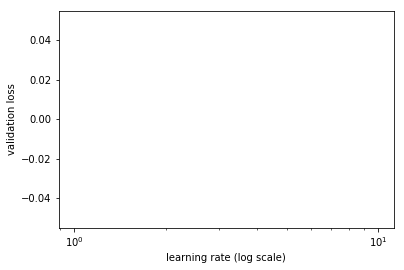

In [486]:
m.sched.plot(100)